# Problem 1: Sparse Encoding for Image Denoising (30pts)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

# Hyperparameters
input_dim = 28 * 28  # MNIST images are 28x28
hidden_dim = int(1.5 * input_dim)  # 1.5 times the input dimension i.e., 1176
batch_size = 128
learning_rate = 1e-3
num_epochs = 20
sigma = 0.5  # Standard deviation for Gaussian noise
lambda_l1 = 1e-3  # Regularization parameter for L1 loss
num_ista_steps = 5  # Reduced Number of ISTA iterations
eta = 1e-3  # Step size for ISTA

# Device configuration using mps if available
device = torch.device('cpu')
print(f'Using device: {device}')

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform,
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform,
                              download=True)

# Data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

def ista(D, X, lambda_l1, num_steps=5, eta=1e-3):
    """
    Perform ISTA to solve the LASSO problem for sparse coding.

    Args:
        D (torch.Tensor): Dictionary matrix of shape [input_dim, hidden_dim].
        X (torch.Tensor): Batch of input data of shape [batch_size, input_dim].
        lambda_l1 (float): Regularization parameter.
        num_steps (int): Number of ISTA iterations.
        eta (float): Step size.

    Returns:
        H (torch.Tensor): Sparse codes of shape [batch_size, hidden_dim].
    """
    batch_size = X.size(0)
    hidden_dim = D.size(1)

    # Initialize H with zeros
    H = torch.zeros(batch_size, hidden_dim, device=X.device, requires_grad=True)

    for _ in range(num_steps):
        # Gradient step
        residual = X - H @ D.t()  # [batch_size, input_dim]
        gradient = -residual @ D  # [batch_size, hidden_dim]
        H = H - eta * gradient

        # Soft-thresholding (differentiable)
        H = torch.nn.functional.softshrink(H, lambd=eta * lambda_l1)

    return H

# Initialize Dictionary D with normalization
D = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01, requires_grad=True).to(device)

# Optimizer for Dictionary D
optimizer_D = optim.Adam([D], lr=learning_rate)

def add_noise(x, sigma):
    noise = torch.randn_like(x) * sigma
    noisy = x + noise
    noisy = torch.clamp(noisy, 0., 1.)
    return noisy

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        data = data.view(-1, input_dim).to(device)
        noisy_data = add_noise(data, sigma)

        # Perform ISTA to get sparse codes H (remove torch.no_grad())
        H = ista(D, noisy_data, lambda_l1, num_steps=num_ista_steps, eta=eta)

        # Forward pass: Reconstruct X_hat = H D^T
        X_hat = torch.matmul(H, D.t())  # [batch_size, input_dim]

        # Compute loss: ||X - D H||_F^2 + lambda ||H||_1
        loss_reconstruction = torch.mean((data - X_hat) ** 2)
        loss_sparse = torch.mean(torch.abs(H))
        loss = loss_reconstruction + lambda_l1 * loss_sparse

        # Backward pass and optimization
        optimizer_D.zero_grad()
        loss.backward()
        optimizer_D.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

Using device: cpu


Epoch [1/20], Loss: 0.054675


Epoch [2/20], Loss: 0.033677


Epoch [3/20], Loss: 0.027567


Epoch [4/20], Loss: 0.025384


Epoch [5/20], Loss: 0.024453


Epoch [6/20], Loss: 0.024032


Epoch [7/20], Loss: 0.023820


Epoch [8/20], Loss: 0.023713


Epoch [9/20], Loss: 0.023641


Epoch [10/20], Loss: 0.023569


Epoch [11/20], Loss: 0.023558


Epoch [12/20], Loss: 0.023523


Epoch [13/20], Loss: 0.023496


Epoch [14/20], Loss: 0.023483


Epoch [15/20], Loss: 0.023474


Epoch [16/20], Loss: 0.023471


Epoch [17/20], Loss: 0.023466


Epoch [18/20], Loss: 0.022944


Epoch [19/20], Loss: 0.022774


Epoch [20/20], Loss: 0.022764


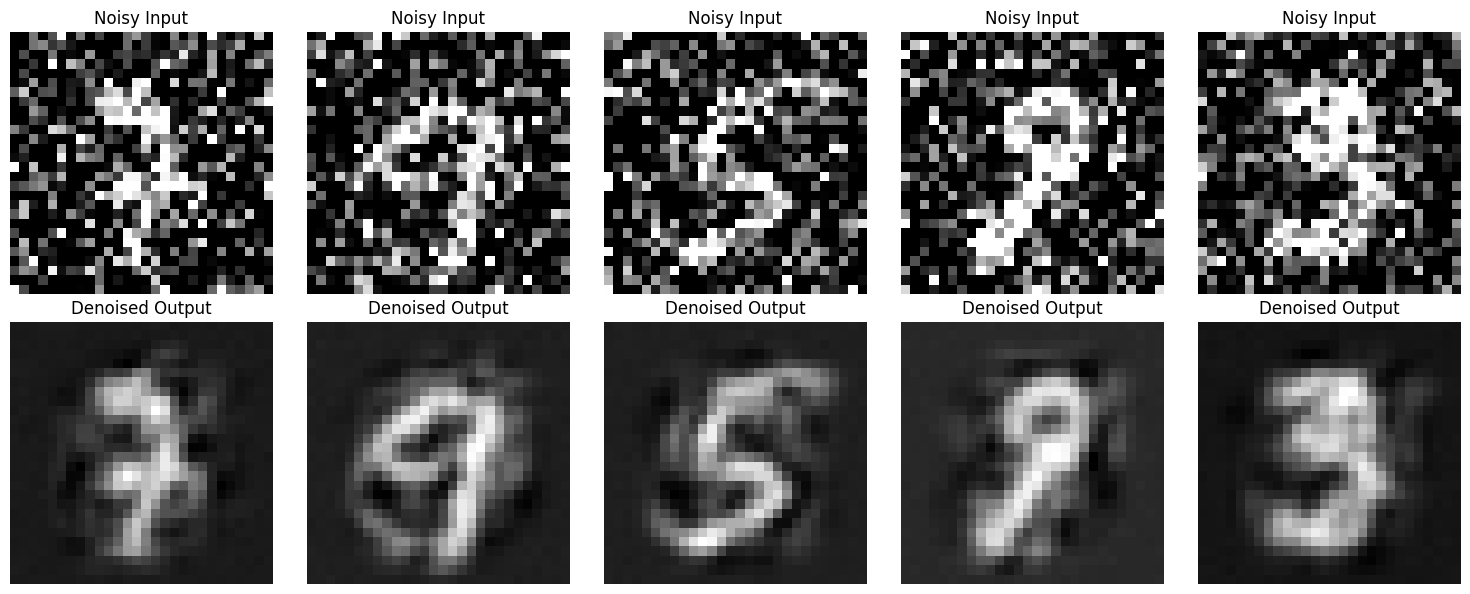

In [23]:
# Switch to evaluation mode
D.requires_grad = False

# Get a batch from the test loader
test_iter = iter(test_loader)
test_images, _ = next(test_iter)
test_images = test_images.view(-1, input_dim).to(device)

# Select 5 random samples
indices = random.sample(range(test_images.size(0)), 5)
sample_images = test_images[indices]
noisy_samples = add_noise(sample_images, sigma)

# Perform ISTA to get sparse codes for noisy samples
H_sample = ista(D, noisy_samples, lambda_l1, num_steps=num_ista_steps, eta=eta)

# Reconstruct the images
reconstructed = torch.matmul(H_sample, D.t())

# Move to CPU and reshape for plotting
sample_images = sample_images.cpu().numpy()
noisy_samples = noisy_samples.cpu().numpy()
# Detach the reconstructed tensor before converting to NumPy
reconstructed = reconstructed.detach().cpu().numpy()

# Plotting
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Noisy input
    axes[0, i].imshow(noisy_samples[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title('Noisy Input')
    axes[0, i].axis('off')
    
    # Denoised output
    axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title('Denoised Output')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Computing H for Test Set: 100%|██████████| 79/79 [00:00<00:00, 161.89it/s]


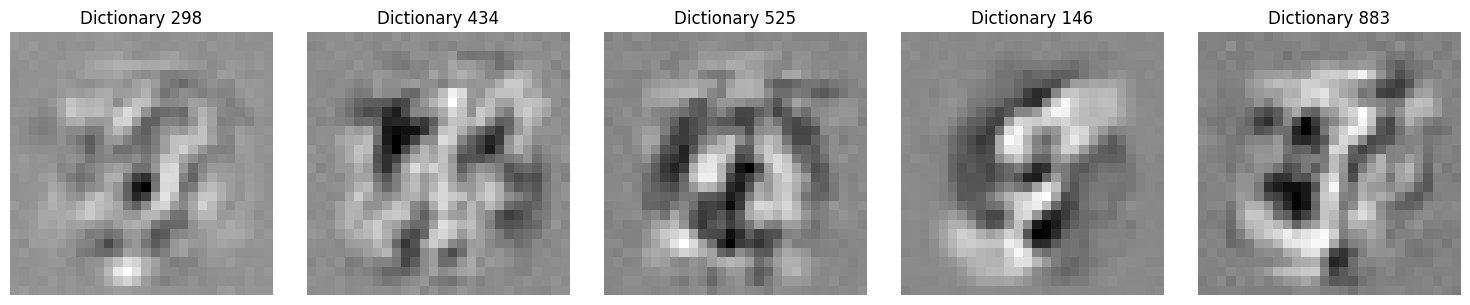

In [26]:
# Compute the average absolute activation for each dictionary atom
with torch.no_grad():
    # Perform ISTA on the entire test set to get H
    all_H = []
    for data, _ in tqdm(test_loader, desc="Computing H for Test Set"):
        data = data.view(-1, input_dim).to(device)
        noisy_data = add_noise(data, sigma)
        H = ista(D, noisy_data, lambda_l1, num_steps=num_ista_steps, eta=1e-3)
        all_H.append(torch.abs(H))
    all_H = torch.cat(all_H, dim=0)  # [num_test_samples, hidden_dim]
    
    # Compute average |h_i| for each dictionary atom
    avg_H = torch.mean(all_H, dim=0)  # [hidden_dim]
    
    # Get indices of top 5 atoms
    top5_indices = torch.topk(avg_H, 5).indices.cpu().numpy()
    
    # Get the corresponding dictionary vectors
    D_matrix = D.detach().cpu().numpy()  # [input_dim, hidden_dim]
    top5_D = D_matrix[:, top5_indices]  # [input_dim, 5]
    
    # Plot the top 5 dictionary atoms
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axes[i].imshow(top5_D[:, i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f'Dictionary {top5_indices[i]}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


# Probem 2: Modified Probablistic PCA on MNIST (30pts)

Using device: cpu

=== Training PPCA with latent dimension: 2 ===


Epoch [1/50] Average Loss per Sample: 12.3720


Epoch [2/50] Average Loss per Sample: -106.2065


Epoch [3/50] Average Loss per Sample: -196.0150


Epoch [4/50] Average Loss per Sample: -277.4968


Epoch [5/50] Average Loss per Sample: -353.4856


Epoch [6/50] Average Loss per Sample: -425.1041


Epoch [7/50] Average Loss per Sample: -490.6613


Epoch [8/50] Average Loss per Sample: -550.5650


Epoch [9/50] Average Loss per Sample: -605.5955


Epoch [10/50] Average Loss per Sample: -656.2015


Epoch [11/50] Average Loss per Sample: -702.7090


Epoch [12/50] Average Loss per Sample: -745.3960


Epoch [13/50] Average Loss per Sample: -784.6766


Epoch [14/50] Average Loss per Sample: -820.8715


Epoch [15/50] Average Loss per Sample: -854.2117


Epoch [16/50] Average Loss per Sample: -885.0306


Epoch [17/50] Average Loss per Sample: -913.4754


Epoch [18/50] Average Loss per Sample: -939.7554


Epoch [19/50] Average Loss per Sample: -963.9742


Epoch [20/50] Average Loss per Sample: -986.1884


Epoch [21/50] Average Loss per Sample: -1006.4121


Epoch [22/50] Average Loss per Sample: -1024.3754


Epoch [23/50] Average Loss per Sample: -1039.9996


Epoch [24/50] Average Loss per Sample: -1053.2772


Epoch [25/50] Average Loss per Sample: -1064.2526


Epoch [26/50] Average Loss per Sample: -1073.1705


Epoch [27/50] Average Loss per Sample: -1080.3689


Epoch [28/50] Average Loss per Sample: -1085.9796


Epoch [29/50] Average Loss per Sample: -1090.4725


Epoch [30/50] Average Loss per Sample: -1094.0056


Epoch [31/50] Average Loss per Sample: -1096.8391


Epoch [32/50] Average Loss per Sample: -1099.2039


Epoch [33/50] Average Loss per Sample: -1101.0372


Epoch [34/50] Average Loss per Sample: -1102.6385


Epoch [35/50] Average Loss per Sample: -1103.9297


Epoch [36/50] Average Loss per Sample: -1105.0314


Epoch [37/50] Average Loss per Sample: -1105.9671


Epoch [38/50] Average Loss per Sample: -1106.7856


Epoch [39/50] Average Loss per Sample: -1107.4747


Epoch [40/50] Average Loss per Sample: -1108.0632


Epoch [41/50] Average Loss per Sample: -1108.5745


Epoch [42/50] Average Loss per Sample: -1109.0317


Epoch [43/50] Average Loss per Sample: -1109.4641


Epoch [44/50] Average Loss per Sample: -1109.7892


Epoch [45/50] Average Loss per Sample: -1110.1051


Epoch [46/50] Average Loss per Sample: -1110.4493


Epoch [47/50] Average Loss per Sample: -1110.6145


Epoch [48/50] Average Loss per Sample: -1110.8373


Epoch [49/50] Average Loss per Sample: -1111.1178


Epoch [50/50] Average Loss per Sample: -1111.2440


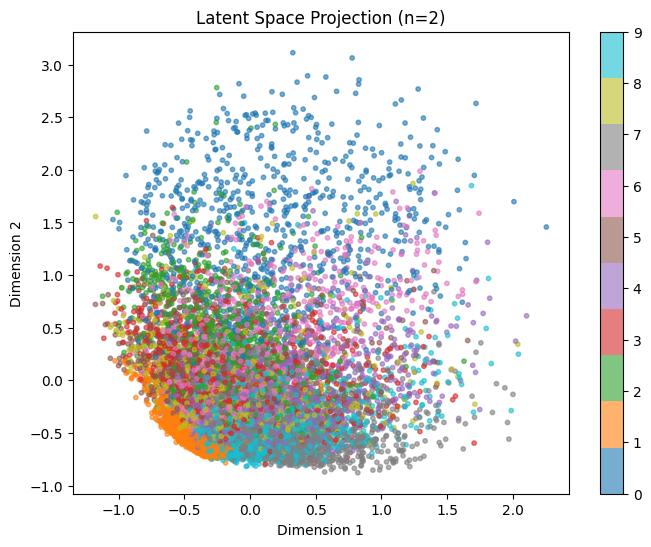

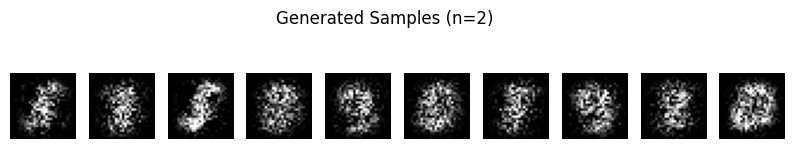


=== Training PPCA with latent dimension: 4 ===


Epoch [1/50] Average Loss per Sample: -13.4224


Epoch [2/50] Average Loss per Sample: -134.7942


Epoch [3/50] Average Loss per Sample: -225.5175


Epoch [4/50] Average Loss per Sample: -307.5314


Epoch [5/50] Average Loss per Sample: -382.8483


Epoch [6/50] Average Loss per Sample: -452.4642


Epoch [7/50] Average Loss per Sample: -516.9734


Epoch [8/50] Average Loss per Sample: -576.6569


Epoch [9/50] Average Loss per Sample: -631.7089


Epoch [10/50] Average Loss per Sample: -682.3474


Epoch [11/50] Average Loss per Sample: -728.8422


Epoch [12/50] Average Loss per Sample: -771.5307


Epoch [13/50] Average Loss per Sample: -810.7406


Epoch [14/50] Average Loss per Sample: -846.8593


Epoch [15/50] Average Loss per Sample: -880.1726


Epoch [16/50] Average Loss per Sample: -910.9494


Epoch [17/50] Average Loss per Sample: -939.3802


Epoch [18/50] Average Loss per Sample: -965.5858


Epoch [19/50] Average Loss per Sample: -989.8220


Epoch [20/50] Average Loss per Sample: -1011.9516


Epoch [21/50] Average Loss per Sample: -1032.1017


Epoch [22/50] Average Loss per Sample: -1050.0360


Epoch [23/50] Average Loss per Sample: -1065.6380


Epoch [24/50] Average Loss per Sample: -1078.8026


Epoch [25/50] Average Loss per Sample: -1089.7887


Epoch [26/50] Average Loss per Sample: -1098.7297


Epoch [27/50] Average Loss per Sample: -1105.7857


Epoch [28/50] Average Loss per Sample: -1111.3541


Epoch [29/50] Average Loss per Sample: -1115.8592


Epoch [30/50] Average Loss per Sample: -1119.4817


Epoch [31/50] Average Loss per Sample: -1122.2318


Epoch [32/50] Average Loss per Sample: -1124.5200


Epoch [33/50] Average Loss per Sample: -1126.4517


Epoch [34/50] Average Loss per Sample: -1127.9418


Epoch [35/50] Average Loss per Sample: -1129.2926


Epoch [36/50] Average Loss per Sample: -1130.4246


Epoch [37/50] Average Loss per Sample: -1131.2075


Epoch [38/50] Average Loss per Sample: -1132.0471


Epoch [39/50] Average Loss per Sample: -1132.7584


Epoch [40/50] Average Loss per Sample: -1133.3254


Epoch [41/50] Average Loss per Sample: -1133.8644


Epoch [42/50] Average Loss per Sample: -1134.1197


Epoch [43/50] Average Loss per Sample: -1134.7192


Epoch [44/50] Average Loss per Sample: -1135.0466


Epoch [45/50] Average Loss per Sample: -1135.3283


Epoch [46/50] Average Loss per Sample: -1135.5569


Epoch [47/50] Average Loss per Sample: -1135.8994


Epoch [48/50] Average Loss per Sample: -1136.0650


Epoch [49/50] Average Loss per Sample: -1136.2883


Epoch [50/50] Average Loss per Sample: -1136.5160


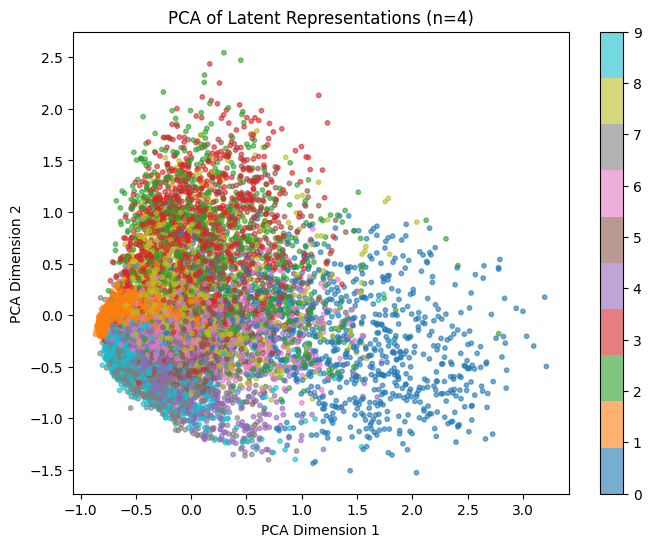

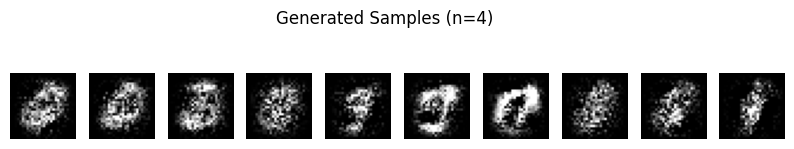


=== Training PPCA with latent dimension: 8 ===


Epoch [1/50] Average Loss per Sample: -43.3209


Epoch [2/50] Average Loss per Sample: -167.5848


Epoch [3/50] Average Loss per Sample: -258.6331


Epoch [4/50] Average Loss per Sample: -341.2056


Epoch [5/50] Average Loss per Sample: -416.8841


Epoch [6/50] Average Loss per Sample: -486.6454


Epoch [7/50] Average Loss per Sample: -551.1426


Epoch [8/50] Average Loss per Sample: -610.8212


Epoch [9/50] Average Loss per Sample: -665.8457


Epoch [10/50] Average Loss per Sample: -716.5016


Epoch [11/50] Average Loss per Sample: -762.9813


Epoch [12/50] Average Loss per Sample: -805.6257


Epoch [13/50] Average Loss per Sample: -844.8076


Epoch [14/50] Average Loss per Sample: -880.9105


Epoch [15/50] Average Loss per Sample: -914.0970


Epoch [16/50] Average Loss per Sample: -944.7609


Epoch [17/50] Average Loss per Sample: -973.0792


Epoch [18/50] Average Loss per Sample: -999.2323


Epoch [19/50] Average Loss per Sample: -1023.2807


Epoch [20/50] Average Loss per Sample: -1045.3320


Epoch [21/50] Average Loss per Sample: -1065.2775


Epoch [22/50] Average Loss per Sample: -1082.9989


Epoch [23/50] Average Loss per Sample: -1098.4285


Epoch [24/50] Average Loss per Sample: -1111.4684


Epoch [25/50] Average Loss per Sample: -1122.3948


Epoch [26/50] Average Loss per Sample: -1131.1459


Epoch [27/50] Average Loss per Sample: -1138.2554


Epoch [28/50] Average Loss per Sample: -1143.7506


Epoch [29/50] Average Loss per Sample: -1148.1594


Epoch [30/50] Average Loss per Sample: -1151.6779


Epoch [31/50] Average Loss per Sample: -1154.6423


Epoch [32/50] Average Loss per Sample: -1156.6848


Epoch [33/50] Average Loss per Sample: -1158.8609


Epoch [34/50] Average Loss per Sample: -1160.1308


Epoch [35/50] Average Loss per Sample: -1161.5717


Epoch [36/50] Average Loss per Sample: -1162.2290


Epoch [37/50] Average Loss per Sample: -1163.6162


Epoch [38/50] Average Loss per Sample: -1164.1275


Epoch [39/50] Average Loss per Sample: -1164.5765


Epoch [40/50] Average Loss per Sample: -1165.3679


Epoch [41/50] Average Loss per Sample: -1165.7354


Epoch [42/50] Average Loss per Sample: -1166.1756


Epoch [43/50] Average Loss per Sample: -1166.9236


Epoch [44/50] Average Loss per Sample: -1166.9913


Epoch [45/50] Average Loss per Sample: -1167.4914


Epoch [46/50] Average Loss per Sample: -1167.6725


Epoch [47/50] Average Loss per Sample: -1167.6160


Epoch [48/50] Average Loss per Sample: -1168.1674


Epoch [49/50] Average Loss per Sample: -1168.3032


Epoch [50/50] Average Loss per Sample: -1168.0554


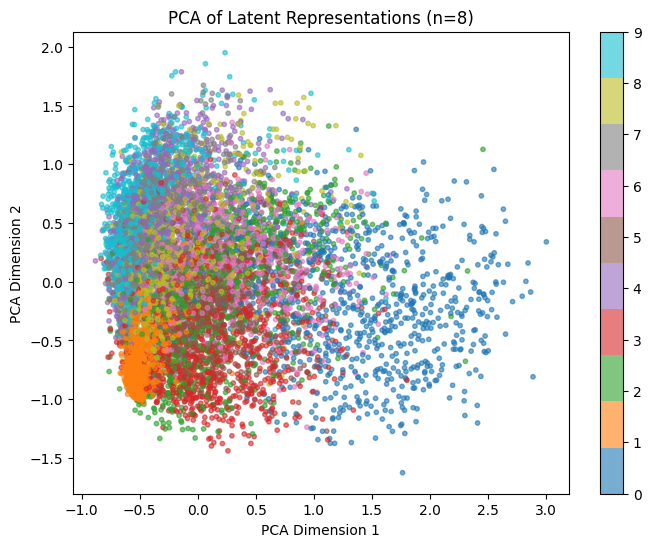

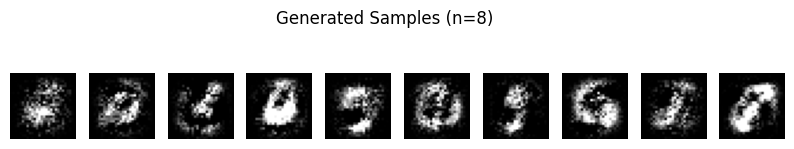


=== Training PPCA with latent dimension: 32 ===


Epoch [1/50] Average Loss per Sample: -105.2608


Epoch [2/50] Average Loss per Sample: -248.7468


Epoch [3/50] Average Loss per Sample: -350.1512


Epoch [4/50] Average Loss per Sample: -436.9280


Epoch [5/50] Average Loss per Sample: -515.1049


Epoch [6/50] Average Loss per Sample: -586.6924


Epoch [7/50] Average Loss per Sample: -652.3960


Epoch [8/50] Average Loss per Sample: -712.5939


Epoch [9/50] Average Loss per Sample: -767.7468


Epoch [10/50] Average Loss per Sample: -818.2837


Epoch [11/50] Average Loss per Sample: -864.5713


Epoch [12/50] Average Loss per Sample: -906.7431


Epoch [13/50] Average Loss per Sample: -945.4876


Epoch [14/50] Average Loss per Sample: -980.8520


Epoch [15/50] Average Loss per Sample: -1013.2056


Epoch [16/50] Average Loss per Sample: -1042.9616


Epoch [17/50] Average Loss per Sample: -1070.3393


Epoch [18/50] Average Loss per Sample: -1095.0091


Epoch [19/50] Average Loss per Sample: -1117.6921


Epoch [20/50] Average Loss per Sample: -1137.7820


Epoch [21/50] Average Loss per Sample: -1155.9080


Epoch [22/50] Average Loss per Sample: -1171.7213


Epoch [23/50] Average Loss per Sample: -1186.1474


Epoch [24/50] Average Loss per Sample: -1196.9948


Epoch [25/50] Average Loss per Sample: -1206.4694


Epoch [26/50] Average Loss per Sample: -1215.4907


Epoch [27/50] Average Loss per Sample: -1221.2312


Epoch [28/50] Average Loss per Sample: -1226.4123


Epoch [29/50] Average Loss per Sample: -1231.0647


Epoch [30/50] Average Loss per Sample: -1231.8399


Epoch [31/50] Average Loss per Sample: -1236.3201


Epoch [32/50] Average Loss per Sample: -1235.1413


Epoch [33/50] Average Loss per Sample: -1239.7384


Epoch [34/50] Average Loss per Sample: -1240.4908


Epoch [35/50] Average Loss per Sample: -1239.5479


Epoch [36/50] Average Loss per Sample: -1242.7214


Epoch [37/50] Average Loss per Sample: -1242.5958


Epoch [38/50] Average Loss per Sample: -1244.2827


Epoch [39/50] Average Loss per Sample: -1242.7225


Epoch [40/50] Average Loss per Sample: -1245.9998


Epoch [41/50] Average Loss per Sample: -1242.4134


Epoch [42/50] Average Loss per Sample: -1243.7631


Epoch [43/50] Average Loss per Sample: -1245.5931


Epoch [44/50] Average Loss per Sample: -1245.6963


Epoch [45/50] Average Loss per Sample: -1243.6741


Epoch [46/50] Average Loss per Sample: -1246.1387


Epoch [47/50] Average Loss per Sample: -1243.7170


Epoch [48/50] Average Loss per Sample: -1236.9548


Epoch [49/50] Average Loss per Sample: -1244.3864


Epoch [50/50] Average Loss per Sample: -1245.1303


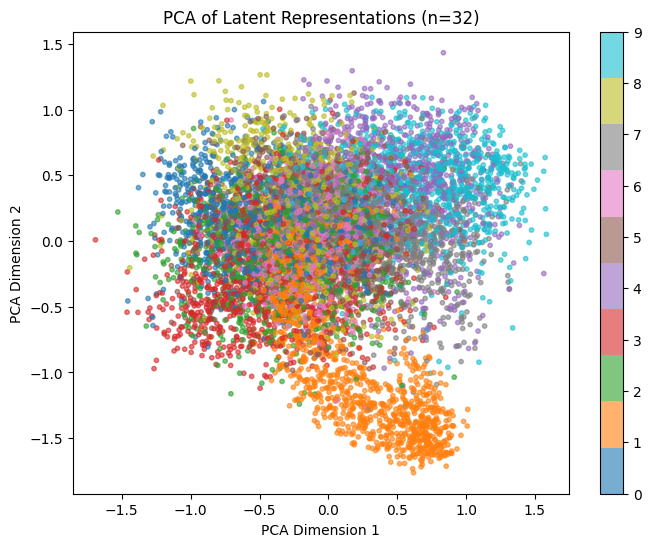

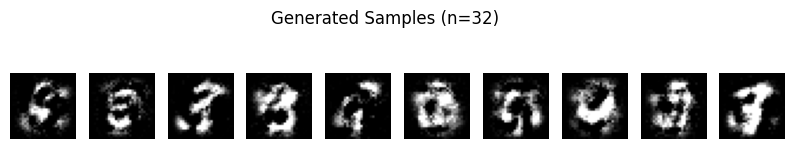

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

# Define the PPCA model
class PPCA(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(PPCA, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Initialize W, mu, and log_sigma as learnable parameters
        self.W = nn.Parameter(torch.randn(input_dim, latent_dim) * 0.01)
        self.mu = nn.Parameter(torch.zeros(input_dim))
        # Initialize log_sigma with small positive values to avoid numerical issues
        self.log_sigma = nn.Parameter(torch.log(torch.ones(input_dim) * 0.1))

    def forward(self, x):
        r"""
        Computes the negative log-likelihood for PPCA:
        \[
        \ell (W, \mu, \sigma^2) = \sum_{i=1}^N \left( \frac{1}{2} \left( D \log(2\pi) + \log |C| + (x^{(i)} - \mu)^T C^{-1} (x^{(i)} - \mu) \right) \right)
        \]
        where \( C = W W^T + \text{diag}(\sigma^2) \).
        """
        batch_size = x.size(0)
        # Compute sigma^2 = exp(log_sigma) to ensure positivity
        sigma2 = torch.exp(self.log_sigma)  # Shape: [D]
        # Construct covariance matrix C = W W^T + diag(sigma^2)
        C = self.W @ self.W.t() + torch.diag(sigma2)  # Shape: [D, D]

        # Center the data
        x_centered = x - self.mu  # Shape: [batch_size, D]

        # Cholesky decomposition for numerical stability
        epsilon = 1e-6
        try:
            L = torch.linalg.cholesky(C + epsilon * torch.eye(self.input_dim, device=x.device))
        except RuntimeError as e:
            # If Cholesky fails, increase epsilon
            epsilon *= 10
            L = torch.linalg.cholesky(C + epsilon * torch.eye(self.input_dim, device=x.device))

        # Compute log determinant: log|C| = 2 * sum(log(diag(L)))
        log_det_C = 2.0 * torch.sum(torch.log(torch.diagonal(L)))

        # Solve L y = (x - mu).T
        y = torch.linalg.solve_triangular(L, x_centered.t(), upper=False)
        # Compute quadratic term: sum over batch of (y^T y)
        quad_form = torch.sum(y ** 2)

        # Compute the loss
        loss = 0.5 * batch_size * (self.input_dim * torch.log(torch.tensor(2.0 * np.pi)) + log_det_C) + 0.5 * quad_form

        return loss

# Define the training function
def train_ppca(latent_dim, train_loader, device, num_epochs=50, learning_rate=1e-3):
    input_dim = 28 * 28  # MNIST images are 28x28
    model = PPCA(input_dim=input_dim, latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as tepoch:
            for data, _ in tepoch:
                data = data.view(-1, input_dim).to(device)  # Flatten the images
                optimizer.zero_grad()
                loss = model(data)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())
        # Compute average loss per sample
        avg_epoch_loss = epoch_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss per Sample: {avg_epoch_loss:.4f}")
    return model

# Visualization function remains the same
def visualize_latent_space(model, test_loader, device, latent_dim, n_components=2):
    """
    Projects the test set into the latent space and visualizes it.
    For n_components=2, creates a 2D scatter plot.
    For higher dimensions, applies PCA for visualization.
    """
    model.eval()
    latent_representations = []
    labels_list = []
    with torch.no_grad():
        sigma2 = torch.exp(model.log_sigma)  # Shape: [D]
        C = model.W @ model.W.t() + torch.diag(sigma2)
        epsilon = 1e-6
        try:
            L = torch.linalg.cholesky(C + epsilon * torch.eye(model.input_dim, device=device))
        except RuntimeError as e:
            epsilon *= 10
            L = torch.linalg.cholesky(C + epsilon * torch.eye(model.input_dim, device=device))

        # Compute C^{-1} W
        temp = torch.linalg.solve_triangular(L, model.W, upper=False)
        C_inv_W = torch.linalg.solve_triangular(L.t(), temp, upper=True)  # Shape: [D, n]

        for data, labels in test_loader:
            data = data.view(-1, model.input_dim).to(device)
            x_centered = data - model.mu  # Shape: [batch_size, D]
            # Compute E[z | x] = (W^T C^{-1}) (x - mu)
            temp = torch.linalg.solve_triangular(L, x_centered.t(), upper=False)
            C_inv_x_mu = torch.linalg.solve_triangular(L.t(), temp, upper=True)
            Ez = model.W.t() @ C_inv_x_mu  # Shape: [n, batch_size]
            latent_z = Ez.t()
            latent_representations.append(latent_z.cpu())
            labels_list.append(labels)

    latent_representations = torch.cat(latent_representations, dim=0).numpy()
    labels_list = torch.cat(labels_list, dim=0).numpy()

    if latent_dim == 2:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(latent_representations[:,0], latent_representations[:,1], c=labels_list, cmap='tab10', alpha=0.6, s=10)
        plt.colorbar(scatter, ticks=range(10))
        plt.title(f"Latent Space Projection (n={latent_dim})")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.show()
    else:
        # For higher dimensions, reduce to 2D using PCA for visualization
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(latent_representations)
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels_list, cmap='tab10', alpha=0.6, s=10)
        plt.colorbar(scatter, ticks=range(10))
        plt.title(f"PCA of Latent Representations (n={latent_dim})")
        plt.xlabel("PCA Dimension 1")
        plt.ylabel("PCA Dimension 2")
        plt.show()

def generate_samples(model, device, latent_dim, num_samples=10):
    """
    Generates new samples by sampling z ~ N(0, I) and passing through the PPCA model.
    """
    model.eval()
    with torch.no_grad():
        # Sample z from standard normal
        z = torch.randn(num_samples, latent_dim).to(device)  # Shape: [num_samples, n]
        # Compute x_mean = W z^T + mu
        x_mean = model.W @ z.t() + model.mu.unsqueeze(1)  # Shape: [D, num_samples]
        # Compute sigma^2 = exp(log_sigma)
        sigma2 = torch.exp(model.log_sigma).unsqueeze(1)  # Shape: [D, 1]
        # Sample epsilon ~ N(0, sigma^2)
        epsilon = torch.randn_like(x_mean) * torch.sqrt(sigma2)  # Shape: [D, num_samples]
        # Generate samples
        x_generated = x_mean + epsilon
        x_generated = x_generated.t().cpu().numpy()
        # Clip values to [0,1]
        x_generated = np.clip(x_generated, 0., 1.)

    # Plot the generated samples
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 2))
    for i in range(num_samples):
        axes[i].imshow(x_generated[i].reshape(28, 28), cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f"Generated Samples (n={latent_dim})")
    plt.show()

# Rest of your training code
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform,
                               download=True)
test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform,
                              download=True)
batch_size = 128
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

# Define latent dimensions to experiment with
latent_dims = [2, 4, 8, 32]

# Iterate over different latent dimensions
for latent_dim in latent_dims:
    print(f"\n=== Training PPCA with latent dimension: {latent_dim} ===")
    model = train_ppca(latent_dim=latent_dim,
                      train_loader=train_loader,
                      device=device,
                      num_epochs=50,
                      learning_rate=1e-3)

    # Visualize the latent space
    visualize_latent_space(model, test_loader, device, latent_dim)

    # Generate new samples
    generate_samples(model, device, latent_dim, num_samples=10)
